In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras.layers import *

## **Read Dataset**

In [5]:
df = pd.read_csv("twitter_data.csv", encoding = 'latin',
                names = ['polarity', 'ID', 'Date', 'Query', 'UserName', 'Text'])

In [6]:
df.head()

,polarity,ID,Date,Query,UserName,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   ID        1600000 non-null  int64 
 2   Date      1600000 non-null  object
 3   Query     1600000 non-null  object
 4   UserName  1600000 non-null  object
 5   Text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df = df.sample(frac = 1)
df = df[:50000]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 81583 to 1004168
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  50000 non-null  int64 
 1   ID        50000 non-null  int64 
 2   Date      50000 non-null  object
 3   Query     50000 non-null  object
 4   UserName  50000 non-null  object
 5   Text      50000 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


## **Data Exploring**

In [10]:
df['polarity'].unique()

array([0, 4], dtype=int64)

In [11]:
#replace 4 --> 1
df['polarity'] = df['polarity'].replace(4,1)
df.head()

,polarity,ID,Date,Query,UserName,Text
81583,0,1752766568,Sat May 09 22:55:13 PDT 2009,NO_QUERY,thechrisgriffin,"@martiy Awww, can't even get to the kitchen? ..."
1569830,1,2188470945,Mon Jun 15 21:57:39 PDT 2009,NO_QUERY,keldeefame,@MadameCrow rubbing alchol or baby oil or nai...
516604,0,2191109158,Tue Jun 16 04:32:27 PDT 2009,NO_QUERY,nickking1,is looking forward to 2 weeks in Suffolk from ...
1036426,1,1956341374,Thu May 28 21:40:23 PDT 2009,NO_QUERY,limecello,@spectrummother @euniebarboro @Jeffechino @Jon...
1525554,1,2176882101,Mon Jun 15 04:58:41 PDT 2009,NO_QUERY,SwaroopH,@scorpfromhell Head to http://tr.im/owK0 and c...


In [12]:
df['polarity'].unique()

array([0, 1], dtype=int64)

In [13]:
df['polarity'].value_counts()

1    25037
0    24963
Name: polarity, dtype: int64

In [14]:
#get common words in data
all_words = []
for line in list(df['Text']):
    words = line.split()
    for word in words:
        if (len(word) > 2):
            all_words.append(word.lower())

In [15]:
Counter(all_words).most_common(30)

[('the', 16289),
 ('and', 9396),
 ('you', 7387),
 ('for', 6829),
 ('have', 4337),
 ('that', 3986),
 ("i'm", 3923),
 ('but', 3907),
 ('just', 3879),
 ('with', 3586),
 ('was', 3169),
 ('not', 3108),
 ('this', 2744),
 ('get', 2552),
 ('like', 2436),
 ('are', 2436),
 ('good', 2355),
 ('all', 2234),
 ('out', 2182),
 ("it's", 2082),
 ('now', 2002),
 ('your', 1970),
 ('love', 1917),
 ('day', 1909),
 ('going', 1900),
 ('got', 1839),
 ('from', 1756),
 ('what', 1655),
 ("don't", 1552),
 ('will', 1548)]

## **Data Preprocessing**

In [16]:
#drop un necessary columns
df.drop(['Date', 'ID', 'Query', 'UserName'], axis = 1, inplace = True)

In [17]:
df.tail()

,polarity,Text
1573652,1,"@shaundiviney, How about this one? Cerebral Pa..."
543151,0,"Oops, that last was via @matthelms. My comput..."
1156269,1,"@GujSehambi Looks great, even though my laptop..."
1213596,1,"Listening to the Goon Show, I got it a while b..."
1004168,1,rawr! i'm an apple. bus trips make me sleepy


In [18]:
#convert object type into string type
df['Text'] = df['Text'].astype('str')

In [19]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'when', 'but', 'does', "hadn't", 's', "haven't", 'this', 'above', 'up', 'ours', 'again', 'they', 'doesn', 'won', 'than', 'an', "it's", 'of', 'both', 'a', 'mustn', "that'll", 'he', 'just', 'there', 'once', "won't", 'has', 'which', 'ain', 'further', 'off', 'had', 'because', 'before', 'why', 'few', "isn't", 'as', "couldn't", 'needn', 'doing', 'd', 'shouldn', "you're", 're', 'aren', "aren't", 'its', 'that', 'other', "should've", 'at', 'how', 'between', 'myself', 'she', 'their', 'was', 'through', 'have', 'not', 'his', 'mightn', 'himself', 'ma', 'after', 'wasn', 'no', 'didn', 'with', 'isn', "mightn't", "weren't", 'her', 'ourselves', 'over', 'for', "you'd", 'me', 'them', 'or', 'be', 'we', 'if', "hasn't", 'our', "you've", 'my', 'him', 'here', 'below', "didn't", 'yourself', 'having', 'did', 'weren', 'do', "you'll", 'your', 'couldn', 'it', 'o', 'shan', "wouldn't", 'being', 've', 'most', 'm', 'same', "shouldn't", 'to', 'are', "mustn't", "don't", "needn't", 'will', 'nor', 'and', 'yourselves', 'th

In [20]:
url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
user_pattern = '@[^\s]+'

In [21]:
def Text_Preprocessing(text):
    #convert words into lower case
    text = text.lower()
    text = text[1:]
    
    #remove all URLs
    text = re.sub(url_pattern,'', text)
    
    #remove username starts with @
    text = re.sub(user_pattern,'', text)
    
    #remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    #word tokenization
    tokens = word_tokenize(text)
    
    #remove stopwords
    final_tokens = [w for w in tokens if w not in stop_words]
    
    #perform lemmatization
    word_lemmatizer = WordNetLemmatizer()
    final_text = []
    for token in final_tokens:
        if len(token) > 2:
            word = word_lemmatizer.lemmatize(token)
            final_text.append(word)
    return ' '.join(final_text)

In [22]:
df['Cleaned_Text'] = df['Text'].apply(lambda x: Text_Preprocessing(x))
print("Text Preprocessing Done.")

Text Preprocessing Done.


In [23]:
df.tail(10)

,polarity,Text,Cleaned_Text
355117,0,tired...work tomorrow,iredwork tomorrow
749507,0,I only needed to take it around the block a co...,needed take around block couple time realized ...
62099,0,Got up at 7:15. Just NOW sitting down with co...,715 sitting coffee
592389,0,(@evilhippiechick) i need a hug from that one ...,need hug one guy miss already
1397933,1,"@alliology Oh, got your emails - yes too cheesy",alliology got email yes cheesy
1573652,1,"@shaundiviney, How about this one? Cerebral Pa...",shaundiviney one cerebral palsy may death sent...
543151,0,"Oops, that last was via @matthelms. My comput...",ops last via computer work slow take long back...
1156269,1,"@GujSehambi Looks great, even though my laptop...",gujsehambi look great even though laptop scree...
1213596,1,"Listening to the Goon Show, I got it a while b...",istening goon show got back never listened goo...
1004168,1,rawr! i'm an apple. bus trips make me sleepy,awr apple bus trip make sleepy


## **Data Visualization**

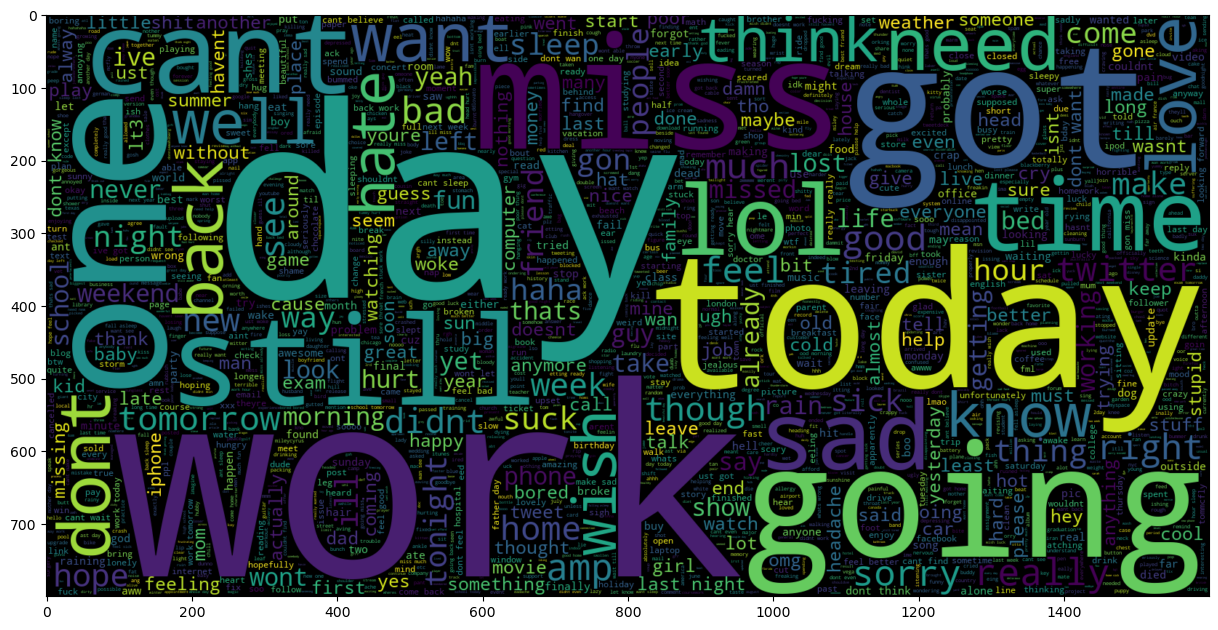

In [24]:
#show negative words
plt.figure(figsize = (15,15))
word_cloud = WordCloud(max_words = 2000, width = 1600, 
                       height = 800).generate(" ".join(df[df.polarity == 0].Cleaned_Text))

plt.imshow(word_cloud, interpolation = 'bilinear')

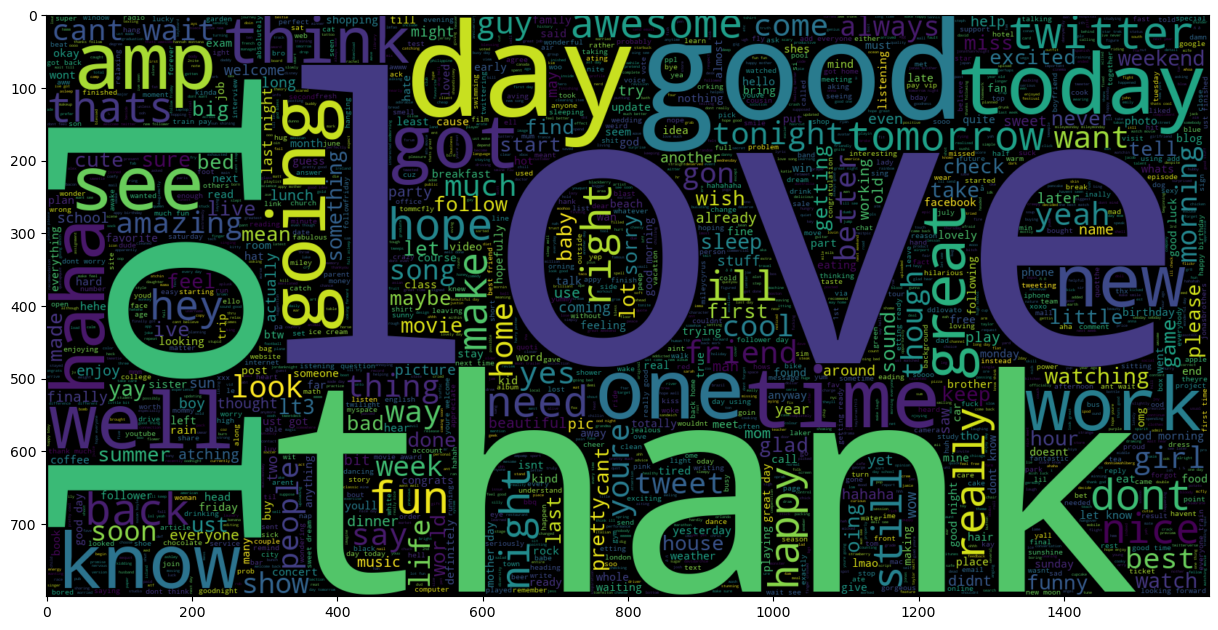

In [25]:
#show positive words
plt.figure(figsize = (15,15))
word_cloud = WordCloud(max_words = 2000, width = 1600, 
                       height = 800).generate(" ".join(df[df.polarity == 1].Cleaned_Text))

plt.imshow(word_cloud, interpolation = 'bilinear')

## **Data Splitting**

In [26]:
#split data into features (x), label (y)
x = df['Cleaned_Text'].values
y = df['polarity'].values

In [27]:
print(x.shape)
print(y.shape)

(50000,)
(50000,)


## **Convert text to Word Frequency**

TF-IDF ---> Term Frequency & Inverse Document Frequency.

Term Frequency: summarize how often a given word appears within a document.

Inverse Document Frequency: Downscales words that appear alot across documents.

In [28]:
vector = TfidfVectorizer()
x = vector.fit_transform(x)

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

def model_evaluation(model):
    train_accuracy = model.score(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    
    print('training accuracy : ', train_accuracy)
    print('testing accuracy : ', test_accuracy)
    
    #prediction
    y_pred = model.predict(x_test)
    
    #classification report
    print(classification_report(y_test, y_pred))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    print(cf_matrix)

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 50)
rf.fit(x_train, y_train)
model_evaluation(rf)

training accuracy :  0.8318857142857143
testing accuracy :  0.7244666666666667
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      7502
           1       0.70      0.80      0.74      7498

    accuracy                           0.72     15000
   macro avg       0.73      0.72      0.72     15000
weighted avg       0.73      0.72      0.72     15000

[[4879 2623]
 [1510 5988]]


In [42]:
import pickle
pickle.dump(model, open('rf.pkl', 'wb'))

In [66]:
# Define the deep learning model
model = Sequential()
model.add(Embedding(input_dim=x_train.shape[1], output_dim=128))
model.add(GlobalAveragePooling1D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
  32/1094 [..............................] - ETA: 42:06 - loss: 0.6944 - accuracy: 0.5078